## Uniform Swarming Simulator

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of the idealized case of a perfectly simulation of bacterial swarming. This solves the ideal case where there is no spatial heterogeneity in the initial nutrient concentration in the system, allowing to avoid needing to resolve the individual branches areas tensor. Additionally, we also treat the system with periodic boundary conditions for simplicity and solve the nutrient PDE pseudospectrally.

We begin by importing all dependencies of interest. 

In [409]:
# Import numerical jax dependencies
import jax
from jax import numpy as jnp
from jax import vmap

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output
import time 

First we will define base parameters associated with branching dynamics.

In [410]:
Parameters = namedtuple(
    "Parameters",
    ["width", "density", "N0", "gamma", "bN", "aC", "KN", "r0", "c0", "DN", "Cm"]
)

Next we will define the parameters of the PDE, including the spatial domain of the system simulation in both physical and wavenumber space. 

In [ ]:
# Define geometry of simulation in time and space. 
L = 120 # Length of side of domain. 
totalT = 20 # Simulation time length
dt = 0.001 # Integration time step
nt = int(totalT/dt) # Number of time steps

# Define the number of nodes of the simualtion. 
nx = 256 # Number of grid points
ny = nx # Number of grid points
dx = L / nx # Grid spacing
dy = dx # Grid spacing

# Create a FD grid
x = jnp.arange(-L/2, L/2,dx)
y = jnp.arange(-L/2, L/2,dy)
XX, YY = jnp.meshgrid(x, y)
RR = jnp.sqrt(XX**2 + YY**2)

# Create an analogous fourier transform of the grid for use in solving the diffusion PDE. 
kx = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)
ky = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)

KX, KY = jnp.meshgrid(kx, ky)
K = jnp.sqrt(KX**2 + KY**2)

Now we fix the parameters associated to the pharmokinetics of the system. For a full description of the meaning of these model parameters, see the original Luo et. al paper from MSB. 

Now we define the first of our jax pure functions to handle updating the state of the system. This specific function will intake the current distribution of the nutrients in the system as well as the current distribution of cells and update the nutrient by numerically solving the reaction-diffusion PDE. 

In [412]:
def pde_update(pde_state, x, pde_params):
    # First we need to unpack the PDE state for the nutrient and cell biomass distribution of the system
    N, C, P = pde_state
    bN, KN, aC, DN, Cm = pde_params
    # First, we compute our reaction term to see how much growth the system will undergo
    fN = N * ((N + KN)**(-1)) * Cm * ((C + Cm)**(-1)) * C
    dN = -bN*fN
    dN_hat = jnp.fft.fft2(dN)

    # Now we solve for the reaction diffusion PDE via fourier space CN timestepping
    N_hat = jnp.fft.fft2(N)
    pre_factor  = (1 + 0.5*DN*(K**2)*dt)**(-1)
    post_factor = (1 - 0.5*DN*(K**2)*dt)
    N_new = jnp.fft.ifft2(pre_factor*(post_factor*N_hat + dN_hat*dt)).real

    #--- Update cell density state ---#
    dC = aC * fN
    C_new = C + dC*dt

    return (N_new,C_new, P), None

Now we'll define a utility function in Jax to compute the PSD between the given set of coordinates. This will be used to assess the density of individual branches to determine bifurcation. 

In [413]:
def pairwise_distances(coordinates):
    
    # Calculate squared distances between all pairs of coordinates
    squared_distances = jnp.sum((coordinates[:, None] - coordinates) ** 2, axis=-1)
    # Take the square root to get the actual distances
    distances = jnp.sqrt(squared_distances)
    return distances

Now we will define the subroutines that will be used in updating the values of the system during the simulation. We have already defined the solver for the PDE step of the system, we will now consider subroutines for initializing and updating the branching tip agents throughout the course of the simulation. 

In [414]:
def init_pde(density, N0, r0, c0):
    """Initialize the PDE parameters for the system."""   
    N = jnp.zeros((nx, ny)) + N0
    P = (RR < r0).astype(jnp.int32)
    C = c0/( jnp.sum(P) * dx * dy)*(P)
    n_tips0 = jnp.maximum(jnp.ceil(2 * jnp.pi * r0 * density),3)  #we assume a minimum of 3 branches

    return (N, C, P), n_tips0

In [415]:
from jax import lax

def init_swarm(num_init_branches, max_tips):
    # Preallocate swarm array and mask
    swarm_array = jnp.zeros((2 * max_tips + 2, 3))
    swarm_mask = jnp.zeros(2 * max_tips + 2)

    # Compute start layer and radial starting index
    #start_layer = jnp.ceil(jnp.log2(max_tips))  # Use max_tips for static indexing
    #start_index = jnp.power(2, start_layer).astype(jnp.int32)

    start_layer = jnp.ceil(jnp.log2(num_init_branches))
    start_index = jnp.power(2, start_layer).astype(jnp.int32)


    # Precompute evenly spaced indices and angles for `max_tips`
    #spacing = max_tips // jnp.maximum(num_init_branches, 1)
    spacing = max_tips / jnp.maximum(num_init_branches, 1)

    indices = jnp.arange(max_tips)
    mask_indices = jnp.round(indices * spacing).astype(jnp.int32) % max_tips

    # Create a mask for valid branches
    valid_mask = indices < num_init_branches
    mask_indices = jnp.where(valid_mask, mask_indices, 0)

    # Compute evenly spaced angles for `num_init_branches`
    angle_step = 2 * jnp.pi / max_tips
    all_angles = jnp.arange(max_tips) * angle_step
    active_angles = jnp.where(valid_mask, all_angles[mask_indices], 0.0)

    # Compute x, y positions based on active_angles
    x_positions = 0.5 * jnp.cos(active_angles)
    y_positions = 0.5 * jnp.sin(active_angles)
    updated_slice = jnp.stack([x_positions, y_positions, active_angles], axis=1)

    # Dynamically update swarm_array and swarm_mask
    swarm_array = lax.dynamic_update_slice(swarm_array, updated_slice, (start_index, 0))
    swarm_mask = lax.dynamic_update_slice(
        swarm_mask, jnp.where(valid_mask, 1.0, 0.0), (start_index,)
    )

    return swarm_array, swarm_mask


In [416]:
# definition of branch computation logic
def branch_update(swarm_state):

    swarm_array, swarm_mask = swarm_state
    
    #get active terminals
    active_terminals = branch_array[:,:]
    #compute pairwise distances between branch points
    distance_matrix = pairwise_distances(active_terminals)
    # compute whether to bifurcate or not
    update_mask = jnp.min(distance_matrix, axis=1, where=jnp.nonzero(distance_matrix))
    # compute number of new terminals to add:
    additional_terminals = jnp.sum(update_mask)
    
    return updated_branch_state

In [417]:
@jax.jit
def bilinear_interpolate(x, y, xp, yp, zp):
    """Given a 2D scalar field N, estimate the value given x, y."""
    ix, iy = jnp.clip(jnp.searchsorted(xp, x, side="right"), 1, len(xp) - 1), jnp.clip(jnp.searchsorted(yp, y, side="right"), 1, len(yp) - 1)
    z_11, z_21, z_12, z_22 = zp[ix - 1, iy - 1], zp[ix, iy - 1], zp[ix - 1, iy], zp[ix, iy]
    dx, dy = xp[ix] - xp[ix - 1], yp[iy] - yp[iy - 1]
    z_xy1 = ((xp[ix] - x) * z_11 + (x - xp[ix - 1]) * z_21) / dx
    z_xy2 = ((xp[ix] - x) * z_12 + (x - xp[ix - 1]) * z_22) / dx
    z = ((yp[iy] - y) * z_xy1 + (y - yp[iy - 1]) * z_xy2) / dy

    return z

@jax.jit
def return_candidates_matrix(x, y, dl):
    n_points = x.shape[0]
    delta = jnp.pi*jnp.linspace(-1,1,N_candidates)
    delta = jnp.tile(delta, (n_points,1) )

    x_candidates = x  + dl*jnp.cos(delta).T
    y_candidates = y  + dl*jnp.sin(delta).T
    
    return x_candidates.T, y_candidates.T, delta

@jax.jit
def compute_optimal_theta(x_candidates, y_candidates, delta,  xp, yp, field):

    # Compare against vecotrized implementaiton
    N_interps_vec = vmap(bilinear_interpolate, in_axes = (0,0,None, None, None))(x_candidates, y_candidates, xp, yp, field.T)

    # Now we need to find the argmax
    argmaxes = jnp.argmax(N_interps_vec, axis = 1)
    col_indices = jnp.arange(argmaxes.shape[0])
    x_opts = x_candidates[col_indices, argmaxes]
    y_opts = y_candidates[col_indices, argmaxes]
    
    theta_opts = delta[col_indices, argmaxes]

    return theta_opts, x_opts, y_opts

In [418]:
@jax.jit
def circ_shader(x_points, y_points, P, width):

    # Compute distances using broadcasting and update P
    distances = jnp.sqrt((XX[..., jnp.newaxis] - x_points)**2 + (YY[..., jnp.newaxis] - y_points)**2)
    P_new = jnp.where(jnp.any(distances < width/2, axis=-1), 1, P)

    return P_new

@jax.jit
def bifurcate( swarm_array, swarm_mask, dl,  eligible_tips):
    i = (swarm_mask * eligible_tips * jnp.arange(swarm_mask.size)).astype(jnp.int32)
    new_mask = swarm_mask.at[2*i].set(1) + swarm_mask.at[2*i + 1].set(1) - swarm_mask*(1 + eligible_tips)

    # Now update swarm_array as well
    rX, rY, theta = swarm_array.T

    theta_new = theta.at[2*i].set(theta[i] + jnp.pi/2) + theta.at[2*i + 1].set(theta[i] - jnp.pi/2)  - theta*(1 + eligible_tips)
    rX_new = new_mask*( rX.at[2*i].set( rX[i] + dl*jnp.cos(theta_new[2*i]) ) + rX.at[2*i +1 ].set( rX[i] + dl*jnp.cos(theta_new[2*i +1]) )  - rX*(1 + eligible_tips) )
    rY_new = new_mask*( rY.at[2*i].set( rY[i] + dl*jnp.sin(theta_new[2*i]) ) + rY.at[2*i +1 ].set( rY[i] + dl*jnp.sin(theta_new[2*i +1]) )  - rY*(1 + eligible_tips) )

    new_swarm_array = jnp.array([ rX_new, rY_new, theta_new ]).T
    
    return (new_swarm_array, new_mask.at[:2].set(0))

In [419]:
N_candidates = 20

@jax.jit
def growth_update(width, density, gamma, swarm_state, pde_state, C_prev):

    # Pull off current PDE state for computations
    N_cur, C_cur, P_cur = pde_state

    # Pull off the active swarm values first
    swarm_array, swarm_mask = swarm_state
    
    # Pull off the x, y, and theta values
    rX, rY, theta = swarm_array.T
    
    # Compute number of active tips
    n_active_tips = jnp.sum(swarm_mask)

    # Compute the total gain in biomass form the system
    dC = (jnp.sum(C_cur*dx*dy) - jnp.sum(C_prev*dx*dy))

    # Compute length of expansions
    dl = gamma*dC/(n_active_tips*width)

    ## BIFURCATE IF NEEDED

    # 1. Compute pairwise distances between nodes 
    pd = pairwise_distances( jnp.tile(swarm_mask, (2,1)).T * swarm_array[:,0:2])

    # Compute a mask indiciating which of the indices need to be bifurcated
    eligible_tips = ( ( jnp.min( pd + 1e7*jnp.eye(pd.shape[0]),axis = 1) ) > 1.5/density ).astype(jnp.int32)

    # Compute the new swarm mask for the system 
    swarm_array, swarm_mask = bifurcate( swarm_array, swarm_mask, dl,  eligible_tips)
    rX, rY, theta = swarm_array.T

    ## GROW

    # 1. Compute optimal growth directions

    # Generate x and y candidates for the 
    x_candidates, y_candidates, delta = return_candidates_matrix(rX, rY, dl)
    theta_opts, x_opts , y_opts = compute_optimal_theta(x_candidates, y_candidates, delta, x, y, N_cur)

    # 2. Actually update the position and pattern matrix but only on the active nodes. 
    new_swarm_array = (jnp.array([x_opts, y_opts, theta_opts])*swarm_mask).T
    
    P_new = circ_shader(x_opts, y_opts, P_cur, width) 
    
    C_new = jnp.sum(C_cur*dx*dy)/(jnp.sum(P_new)*dx*dy)*P_new 

    # 3. Check if a given point is reached the boundary of the system, in which case set it to inactive for the 
    #next iteration. 
    radial_distance = jnp.sqrt( x_opts**2 + y_opts**2 )
    new_swarm_mask =  jnp.where( (radial_distance >= 0.90*L/2), 0, swarm_mask )
    
    # Generate new state and return
    updated_swarm_state = (new_swarm_array, new_swarm_mask)
    C_new = jnp.clip(C_new, 0, None)
    N_cur = jnp.clip(N_cur, 0, None)
    updated_pde_state = (N_cur, C_new, P_new)
    
    return updated_swarm_state, updated_pde_state

And lastly, we define the main simulation loop which performs all the computation. This will seperately call the internal subroutines in the sytem to solve different components of the simulation. 

In [420]:
from functools import partial

SimState = namedtuple("SimState", ["pde_state", "swarm_state"])
num_pde_steps = 3
num_steps = nt

@jax.jit
def run_sim(width, density, N0, gamma, bN, aC, KN, r0, c0, DN, Cm):
    pde_state0, n_tips0 = init_pde(density, N0, r0, c0)
    n_tips0 = jnp.ceil(n_tips0).astype(jnp.int32)
    swarm_state0 = init_swarm(n_tips0, 693)
    init_state = (pde_state0, swarm_state0)
    pde_params = jnp.array([bN, KN, aC, DN, Cm])

# Partial function for scanning over steps
    def sim_step(state, dummy):
        pde_state, swarm_state = state
        _, C, _ = pde_state
    # Partially apply PDE update with parameters
        pde_update_with_params = partial(
        pde_update,
        pde_params = pde_params
    )
    
        updated_pde_state, _ = jax.lax.scan(
            pde_update_with_params, pde_state, jnp.arange(num_pde_steps)
        )
        
        updated_swarm, updated_pde = growth_update(
            width, density, gamma, swarm_state, updated_pde_state, C
        )
        return (updated_pde, updated_swarm), None

    final_state, _ = jax.lax.scan(
        sim_step,
        init_state,
        jnp.arange(num_steps)
    )[0]
    return final_state
run_sim_vectorized = vmap(run_sim, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))



In [421]:
from jax.tree_util import tree_map
from jax.random import uniform, PRNGKey
import jax.numpy as jnp
import time

# Instantiate base parameters
parameters = Parameters(
    width=2,
    density=0.2,
    N0=4,
    gamma=5,
    bN=80,
    aC=0.8,
    KN=0.8,
    r0=4,
    c0=1.0,
    DN=9,
    Cm=0.05,
)

# Define parameter ranges
parameter_ranges = {
    "width": (0.3 * parameters.width, 3 * parameters.width),
    "density": (0.4 * parameters.density, 3 * parameters.density),
    "N0": (0.25 * parameters.N0, 4 * parameters.N0),
    "gamma": (0.25 * parameters.gamma, 4 * parameters.gamma),
    "bN": (0.25 * parameters.bN, 4 * parameters.bN),
    "aC": (0.25 * parameters.aC, 4 * parameters.aC),
    "KN": (0.25 * parameters.KN, 4 * parameters.KN),
    "r0": (0.5 * parameters.r0, 2 * parameters.r0),
    "c0": (0.25 * parameters.c0, 4 * parameters.c0),
    "DN": (parameters.DN,  parameters.DN),
    "Cm": (parameters.Cm, parameters.Cm),
}

# Generate randomized parameters
num_simulations = 25
key = PRNGKey(43)  # Random seed

# Generate randomized parameters in log scale
randomized_parameters = jnp.column_stack([
    jnp.exp(uniform(key, shape=(num_simulations,), minval=jnp.log(low), maxval=jnp.log(high)))
    for low, high in parameter_ranges.values()
])
# Run vectorized simulations
start = time.time()
final_states = run_sim_vectorized(
    randomized_parameters[:, 0],  # widths
    randomized_parameters[:, 1],  # densities
    randomized_parameters[:, 2],  # N0
    randomized_parameters[:, 3],  # gamma
    randomized_parameters[:, 4],  # bN
    randomized_parameters[:, 5],  # aC
    randomized_parameters[:, 6],  # KN
    randomized_parameters[:, 7],  # r0
    randomized_parameters[:, 8],  # c0
    randomized_parameters[:, 9],  # DN
    randomized_parameters[:, 10]  # Cm
)
end = time.time()

print(f"Simulation took {end - start:.2f} seconds")


Simulation took 144.30 seconds


(25, 256, 256)


0it [00:00, ?it/s]

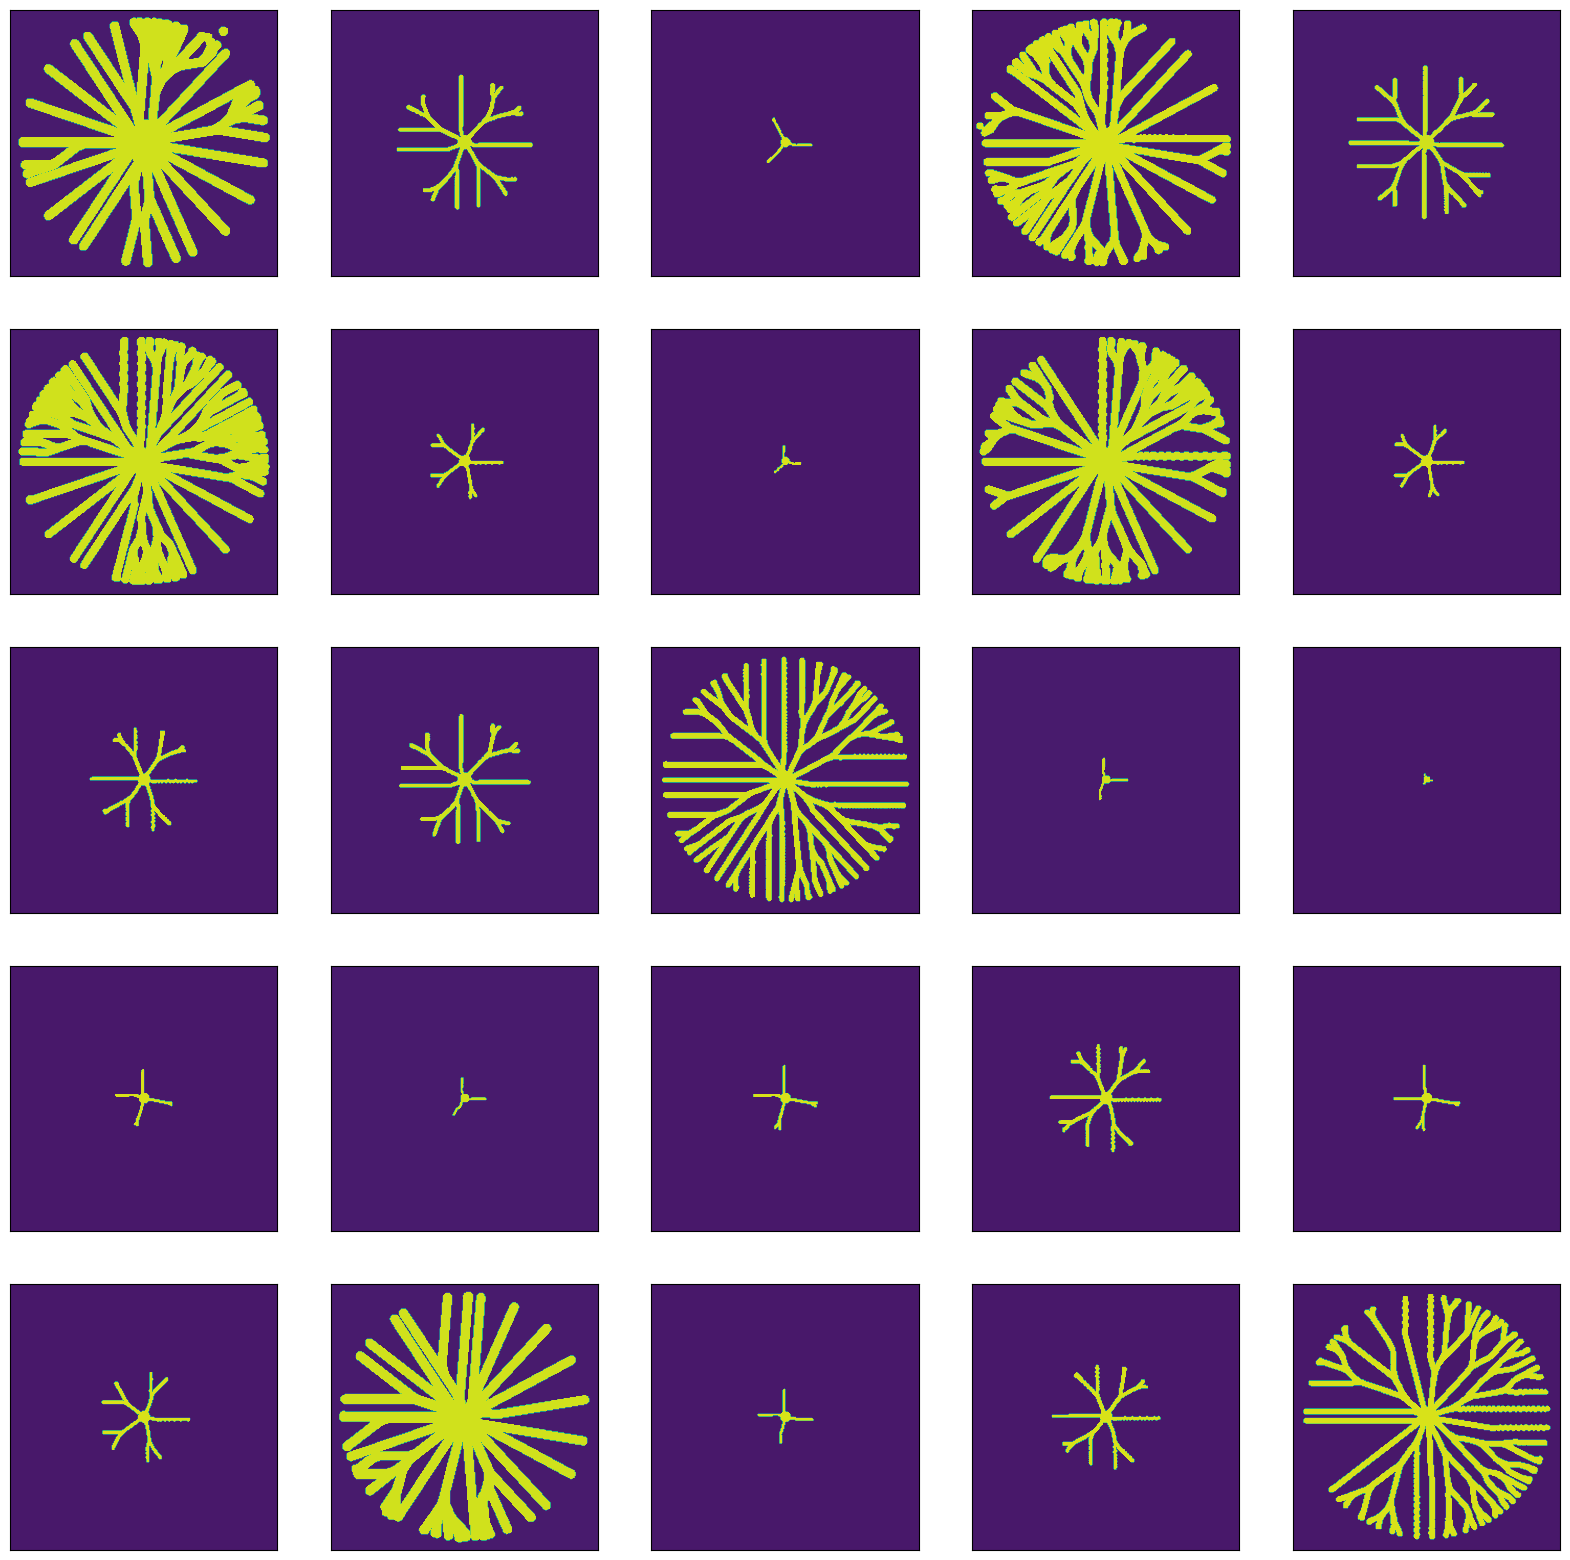

In [422]:
final_patterns = final_states[1]
print(final_patterns.shape)
from tqdm.notebook import tqdm
fig, axs = plt.subplots( 5, 5, figsize = ( 20, 20 ))
axs = axs.flatten()
for i,ax in tqdm(enumerate(axs)):
    #ax.set_title(f"w = {parameters[i,0]:.2f} d = {parameters[i,1]:.2f} ", fontsize = 5)
    #ax.contourf(final_patterns[i])
    ax.contourf(final_patterns[i], origin='lower')  # Aligns with Cartesian grid
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()